# DOE 本番解析用 (base) v6 移動平均・メジアン

### ライブラリの一括インポート

In [21]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [22]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.setting import load_setting
from funcs.tse import get_ticker_name_list
from structs.res import AppRes

### Matplotlib のフォント設定（オプション）

In [23]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### ファイル名から日付を返す関数

In [24]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## 初期設定

In [31]:
name_doe = "doe-12"  # 実験計画名（フォルダ名）
path_doe = os.path.join("..", "doe", f"{name_doe}.csv")

name_code = "7011"  # 銘柄コード
# name_code = "7203"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

df_doe = pd.read_csv(path_doe)
print(df_doe)
factor_doe = list(df_doe.columns)
print(factor_doe)
col_x = factor_doe[0]
col_y = factor_doe[1]

res = AppRes()
dict_setting = load_setting(res, name_code)
df_setting = pd.DataFrame(pd.Series(dict_setting))
df_setting.columns = ["value"]
print("\n設定")
print(df_setting)

x_por = dict_setting[col_x]
y_por = dict_setting[col_y]

# 移動期間
period = 20

     PERIOD_MA_1  PERIOD_MA_2
0             30          300
1             40          300
2             50          300
3             60          300
4             70          300
..           ...          ...
284          150         1100
285          160         1100
286          170         1100
287          180         1100
288          190         1100

[289 rows x 2 columns]
['PERIOD_MA_1', 'PERIOD_MA_2']

設定
                    value
PERIOD_WARMUP      180.00
PERIOD_MA_1         60.00
PERIOD_MA_2        450.00
PERIOD_SLOPE         5.00
THRESHOLD_SLOPE      0.05
PERIOD_RR           30.00
TURBULENCE          35.00
LOSSCUT_1          -25.00
THRESHOLD_PM_MIN    17.50
THRESHOLD_DDR_MIN    0.40


## CSV ファイル一覧の取得

In [6]:
# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
if m := pattern_date.match(file_last):
    date_dir = os.path.join(
        "..", "output", name_doe, f"y{m.group(1)}", m.group(2), m.group(3)
    )
    date_str = date_dir
else:
    date_dir = os.path.join("..", "output", name_doe, "y0000", "00", "00")
    date_str = date_dir
os.makedirs(date_dir, exist_ok=True)
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['result_20250819.csv', 'result_20250820.csv', 'result_20250821.csv', 'result_20250822.csv', 'result_20250825.csv', 'result_20250826.csv', 'result_20250827.csv', 'result_20250828.csv', 'result_20250829.csv', 'result_20250901.csv', 'result_20250902.csv', 'result_20250903.csv', 'result_20250904.csv', 'result_20250905.csv', 'result_20250908.csv', 'result_20250909.csv', 'result_20250910.csv', 'result_20250911.csv', 'result_20250912.csv', 'result_20250916.csv', 'result_20250917.csv', 'result_20250918.csv', 'result_20250919.csv', 'result_20250922.csv', 'result_20250924.csv', 'result_20250925.csv', 'result_20250926.csv', 'result_20250929.csv', 'result_20250930.csv', 'result_20251001.csv', 'result_20251002.csv', 'result_20251003.csv', 'result_20251006.csv', 'result_20251007.csv', 'result_20251008.csv', 'result_20251009.csv', 'result_20251010.csv', 'result_20251014.csv', 'result_20251015.csv', 'result_20251016.csv', 'result_20251017.csv', 'result_20251020.csv', 'result_20251

### 設定情報の保存

In [33]:
# HTML 形式で出力
styled = (
    df_setting.style.format({"value": "{:.3f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_setting.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

## CSV ファイルの読み込み、連結

In [7]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    df_tick = df_tick.astype({"total": float})
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)

list_col = [col_x, col_y, "trade", "total"]
list_col_new = [col_x, col_y, "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

# HTML 形式で出力
styled = (
    df_latest.style.format({"取引回数": "{:d}", "損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_latest_single.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件 [{name_doe}]")
print(df_latest_max)


日毎のシミュレーション結果例（連結前）
                    file  code  trade   total  PERIOD_MA_1  PERIOD_MA_2
0    ticks_20250819.xlsx  7011    100  2500.0           30          300
1    ticks_20250819.xlsx  7011    100  2900.0           40          300
2    ticks_20250819.xlsx  7011     80 -1900.0           50          300
3    ticks_20250819.xlsx  7011     70 -5000.0           60          300
4    ticks_20250819.xlsx  7011     48  1500.0           70          300
..                   ...   ...    ...     ...          ...          ...
284  ticks_20250819.xlsx  7011      8  2400.0          150         1100
285  ticks_20250819.xlsx  7011      4  -400.0          160         1100
286  ticks_20250819.xlsx  7011      4   900.0          170         1100
287  ticks_20250819.xlsx  7011      4  -500.0          180         1100
288  ticks_20250819.xlsx  7011      2  1100.0          190         1100

[289 rows x 6 columns]

日毎のシミュレーション結果を連結したデータフレーム
                      file  code  trade   total  PERIOD_MA_1  PE

### 本日の条件

## 最終日のデータだけで作成した等高線図

In [8]:
plt.rcParams["font.size"] = 12
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

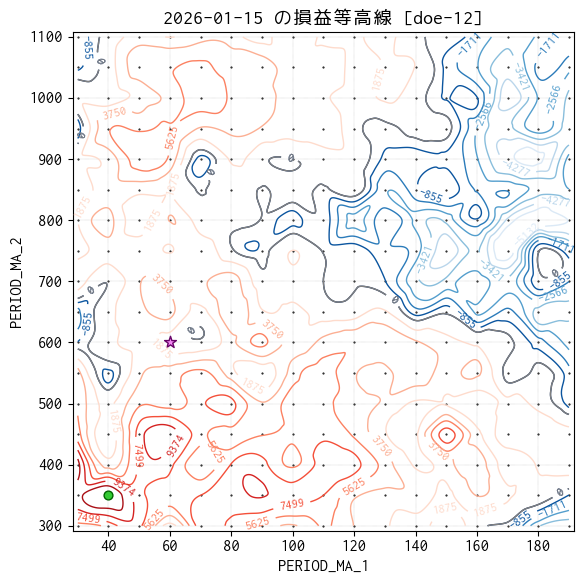

In [9]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

try:
    # z>0 の等高線（暖色）
    levels_pos = np.linspace(0, np.nanmax(Zi), 8)
    cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
    ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
except ValueError as e:
    print("catch ValueError:", e)

try:
    # z<0 の等高線（寒色）
    levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
    cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
    ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
except ValueError as e:
    print("catch ValueError:", e)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.scatter(
    df_latest_max[col_x],
    df_latest_max[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)
ax.scatter(
    x_por,
    y_por,
    marker="*",
    facecolor="#f8f",
    edgecolor="#606",
    s=80,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"{dt_last.date()} の損益等高線 [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

output = os.path.join(date_str, f"{name_code}_contour_single.png")

# plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
# plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

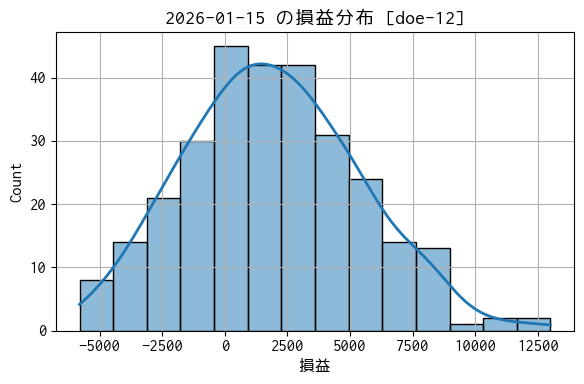

In [10]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df_latest,
    x="損益",
    kde=True,
    line_kws={"linewidth": 2},
    ax=ax,
)
ax.grid()
ax.set_title(f"{dt_last.date()} の損益分布 [{name_doe}]")

plt.tight_layout()
output = os.path.join(date_str, f"{name_code}_hist_single.png")
plt.savefig(output)
plt.show()

## 最大・最小損益（ヒストリカル）

In [11]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高損益")
print(df[df["total"] == total_max])
print("\n最低損益")
print(df[df["total"] == total_min])

最高損益
                      file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2
15165  ticks_20251105.xlsx  7011     54  31100.0           40          700

最低損益
                      file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2
14082  ticks_20251029.xlsx  7011     64 -22800.0           90          900


## 日付 × 条件 で損益を集計

In [12]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で損益")
df_raw = df_raw.astype("float64")
print(df_raw)


df_raw: 日付 x 条件で損益
               0       1       2       3       4       5        6        7    \
2025-08-19  2500.0  2900.0 -1900.0 -5000.0  1500.0  4200.0   2900.0  -3600.0   
2025-08-20  4200.0  2900.0  6600.0  3800.0  5000.0  6600.0   7300.0   6500.0   
2025-08-21  1300.0 -1300.0  2700.0  4700.0  4600.0  4300.0    600.0   1300.0   
2025-08-22 -7300.0 -5000.0 -6000.0 -1700.0 -3700.0 -1500.0   -500.0    500.0   
2025-08-25 -3400.0 -2100.0 -1300.0 -1000.0  -400.0  -200.0   -100.0   -200.0   
...            ...     ...     ...     ...     ...     ...      ...      ...   
2026-01-08 -1300.0 -3700.0 -8700.0 -6500.0 -5100.0 -9800.0 -11400.0 -10800.0   
2026-01-09 -3500.0 -3900.0 -1600.0 -4700.0 -4100.0 -2800.0  -2200.0  -3000.0   
2026-01-13  2500.0  -300.0  6900.0  4600.0  5900.0  4200.0   5700.0   8400.0   
2026-01-14  6300.0  3900.0  5600.0  2100.0 -3900.0 -2200.0   -800.0  -2100.0   
2026-01-15  4600.0  6300.0  8000.0  1200.0  8500.0  6700.0   5000.0   3500.0   

                8  

## 損益の移動平均のトレンド

In [13]:
# 移動平均
df_ma = df_raw.rolling(window=period, min_periods=1).mean()
print(df_ma)
# データスコープを示す文字列
dt_start = df_ma.index[0]
dt_end = df_ma.index[-1]
title_scope = (
    f"{dict_code[name_code]} ({name_code}) "
    f"from {dt_start.date()} to {dt_end.date()} / "
    f"n={n_day}d / "
    f"rolling={period}d"
)
print("データスコープを示す文字列")
print(title_scope)

                    0       1            2            3       4    \
2025-08-19  2500.000000  2900.0 -1900.000000 -5000.000000  1500.0   
2025-08-20  3350.000000  2900.0  2350.000000  -600.000000  3250.0   
2025-08-21  2666.666667  1500.0  2466.666667  1166.666667  3700.0   
2025-08-22   175.000000  -125.0   350.000000   450.000000  1850.0   
2025-08-25  -540.000000  -520.0    20.000000   160.000000  1400.0   
...                 ...     ...          ...          ...     ...   
2026-01-08   330.000000   495.0   485.000000  -225.000000    90.0   
2026-01-09   240.000000   235.0   330.000000  -520.000000  -135.0   
2026-01-13   315.000000   195.0   475.000000  -380.000000    65.0   
2026-01-14   230.000000   -90.0   575.000000  -175.000000  -150.0   
2026-01-15   515.000000    60.0   895.000000  -275.000000   220.0   

                    5       6       7       8            9    ...  \
2025-08-19  4200.000000  2900.0 -3600.0  -900.0  -500.000000  ...   
2025-08-20  5400.000000  5100.0  

### ランキング（移動平均）

In [14]:
# 最終日の移動平均収益のランキング
ser_ma_ranking = df_ma.iloc[len(df_ma) - 1].sort_values(ascending=False)
n_top = 5

# ベスト条件の抽出
best_ma_conditions = list(ser_ma_ranking.index[:n_top])
df_ma_best = df_latest.iloc[best_ma_conditions].copy()[
    factor_doe + ["取引回数", "損益"]
]
dt = df_ma.index[-1]
df_ma_best["損益(MA)"] = (df_ma.loc[dt:][best_ma_conditions].T)[dt]
print("---\n[Best Conditions with latest MA]")
print(df_ma_best)

# HTML 形式で出力
styled = (
    df_ma_best.style.format(
        {"取引回数": "{:.0f}", "損益": "{:.1f}", "損益(MA)": "{:.1f}"}
    )
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の移動平均収益が負になっている実験条件
negative_ma_conditions = ser_ma_ranking[ser_ma_ranking < 0].index
if len(negative_ma_conditions) > 0:
    df_ma_negative = df_latest.iloc[negative_ma_conditions].copy()
    df_ma_negative["損益(MA)"] = (df_ma.loc[dt:][negative_ma_conditions].T)[dt]
    print("---\n[Bad Conditions with latest MA]")
    print(df_ma_negative)

---
[Best Conditions with latest MA]
     PERIOD_MA_1  PERIOD_MA_2  取引回数       損益  損益(MA)
88            60          550    62   4600.0  2535.0
54            60          450    64  10400.0  2275.0
122           60          650    70   4200.0  2120.0
21            70          350    70   7500.0  2000.0
56            80          450    48   4900.0  1905.0
---
[Bad Conditions with latest MA]
     PERIOD_MA_1  PERIOD_MA_2  取引回数      損益 備考  損益(MA)
113          140          600    32  4000.0      -10.0
127          110          650    30   900.0      -20.0
218          170          900    24 -4700.0      -20.0
10           130          300    38  2300.0      -35.0
145          120          700    30  -200.0      -40.0
..           ...          ...   ...     ... ..     ...
196          120          850    28   800.0     -785.0
180          130          800    26 -1100.0     -795.0
178          110          800    34  -400.0     -835.0
181          140          800    30 -2800.0     -960.0
197 

### 条件毎の損益トレンド（移動平均）のチャート

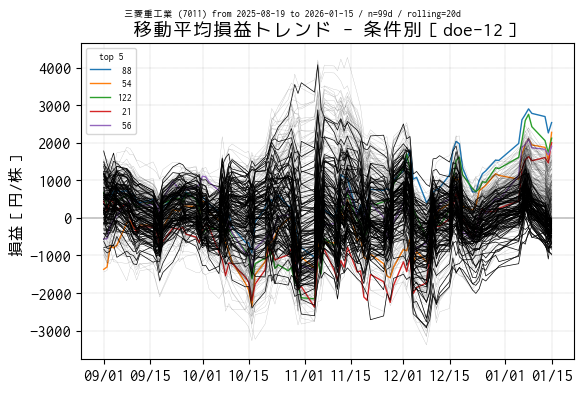

In [15]:
# ---------------------------------------------------------
# 実験条件毎の平均損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_ma[dt_from <= df_ma.index]

for colname in ser_ma_ranking.index:
    if colname in best_ma_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_ma_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.25)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"移動平均損益トレンド - 条件別［{name_doe}］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_ma_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_mean_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 損益の移動メジアンのトレンド

In [16]:
# 移動メジアン
df_mm = df_raw.rolling(window=period, min_periods=1).median()
print(df_mm)

               0       1       2       3       4       5       6       7    \
2025-08-19  2500.0  2900.0 -1900.0 -5000.0  1500.0  4200.0  2900.0 -3600.0   
2025-08-20  3350.0  2900.0  2350.0  -600.0  3250.0  5400.0  5100.0  1450.0   
2025-08-21  2500.0  2900.0  2700.0  3800.0  4600.0  4300.0  2900.0  1300.0   
2025-08-22  1900.0   800.0   400.0  1050.0  3050.0  4250.0  1750.0   900.0   
2025-08-25  1300.0 -1300.0 -1300.0 -1000.0  1500.0  4200.0   600.0   500.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-08 -1000.0   150.0  1300.0  -600.0   400.0   650.0   350.0   650.0   
2026-01-09 -1000.0  -200.0   700.0 -1300.0   250.0  -250.0   350.0   400.0   
2026-01-13 -1000.0  -250.0   700.0 -1300.0   250.0  -250.0   350.0   400.0   
2026-01-14 -1000.0  -250.0   700.0  -600.0  -950.0  -750.0   350.0   400.0   
2026-01-15     0.0  -250.0   700.0  -600.0  -950.0  -750.0   350.0   400.0   

               8       9    ...     279     280     281     282

### ランキング（移動メジアン）

In [17]:
# 最終日の移動メジアン収益のランキング
ser_mm_ranking = df_mm.iloc[len(df_mm) - 1].sort_values(ascending=False)
n_top = 10

# ベスト条件の抽出
best_mm_conditions = list(ser_mm_ranking.index[:n_top])
df_mm_best = df_latest.iloc[best_mm_conditions].copy()[
    factor_doe + ["取引回数", "損益"]
]
dt = df_mm.index[-1]
df_mm_best["損益(MM)"] = (df_mm.loc[dt:][best_mm_conditions].T)[dt]
print("---\n[Best Conditions with latest MM]")
print(df_mm_best)

# HTML 形式で出力
styled = (
    df_mm_best.style.format(
        {"取引回数": "{:.0f}", "損益": "{:.1f}", "損益(MM)": "{:.1f}"}
    )
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best_median.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の移動平均収益が負になっている実験条件
negative_mm_conditions = ser_mm_ranking[ser_mm_ranking < 0].index
if len(negative_mm_conditions) > 0:
    df_mm_negative = df_latest.iloc[negative_mm_conditions].copy()
    df_mm_negative["損益(MM)"] = (df_mm.loc[dt:][negative_mm_conditions].T)[dt]
    print("---\n[Bad Conditions with latest MM]")
    print(df_mm_negative)

---
[Best Conditions with latest MM]
     PERIOD_MA_1  PERIOD_MA_2  取引回数       損益  損益(MM)
85            30          550   100   4500.0  2150.0
54            60          450    64  10400.0  1850.0
21            70          350    70   7500.0  1650.0
87            50          550    72   3300.0  1650.0
155           50          750    56   3200.0  1450.0
121           50          650    76   3100.0  1350.0
188           40          850    52   2900.0  1300.0
140           70          700    50   3200.0  1300.0
102           30          600   100   -800.0  1300.0
53            50          450    68   8300.0  1300.0
---
[Bad Conditions with latest MM]
     PERIOD_MA_1  PERIOD_MA_2  取引回数       損益 備考  損益(MM)
229          110          950    32   3400.0      -50.0
232          140          950    30    600.0      -50.0
237          190          950    20  -4200.0      -50.0
216          150          900    32  -1100.0      -50.0
200          160          850    30  -1800.0      -50.0
..      

### 条件毎の損益トレンド（移動メジアン）のチャート

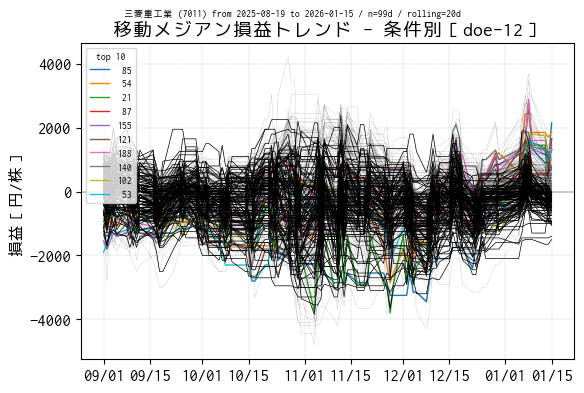

In [18]:
# ---------------------------------------------------------
# 実験条件毎の平均メジアントレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

df_trend = df_mm[dt_from <= df_mm.index]

for colname in ser_mm_ranking.index:
    if colname in best_mm_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_mm_conditions:  # 最新のメジアン収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.25)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"移動メジアン損益トレンド - 条件別［{name_doe}］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_mm_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_median_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

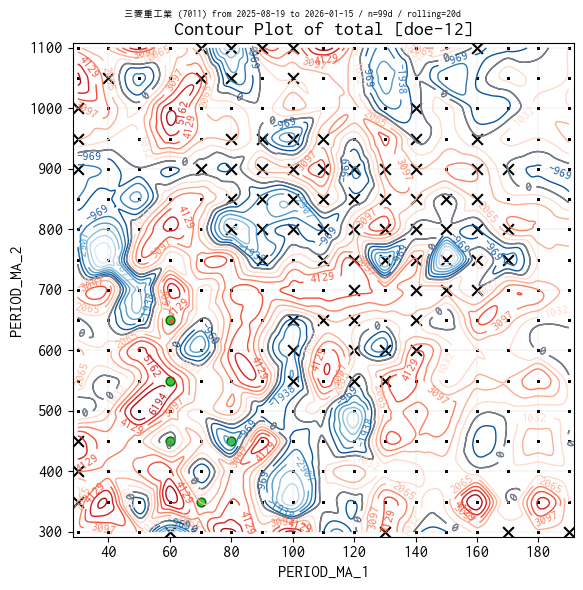

In [19]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"Contour Plot of total [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_ma_best[col_x],
    df_ma_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
if len(negative_ma_conditions) > 0:
    ax.scatter(
        df_ma_negative[col_x],
        df_ma_negative[col_y],
        marker="x",
        color="black",
        s=60,
        zorder=1,
    )

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
output = os.path.join(date_str, f"{name_code}_raw_contour_{target}.png")
plt.savefig(output)
plt.show()